# Data Analysis for OH<sup>-</sup>(H<sub>2</sub>O)<sub>5</sub> DMC Data

### Install necessary libraries and define constants

In [1]:
import numpy as np
import pyvibdmc as pv
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.spatial.distance import pdist
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import joblib
import pandas as pd
from nn_dmc import *

import h5py

au_to_cm = 219474.63136320

au_to_ang = 0.529177249

h11o6_atoms = np.array([8,1,1,8,1,1,8,1,1,8,1,1,8,1,1,8,1])
h11o6_groups = [[0,1,2],[3,4,5],[6,7,8],[9,10,11],[12,13,14],[15,16]]

h11o6_atom_names = ['O','H','H','O','H','H','O','H','H','O','H','H','O','H','H','O','H']

ml_path = 'C:/Users/gjaco/OneDrive/Documents/UW/McCoy Group/Machine Learning'
data_path = 'C:/Users/gjaco/OneDrive/Documents/UW/McCoy Group/H11O6-/Data'

In [29]:
read_xyz_file(f'{ml_path}/h11o6/geometries/h11o6_4_1_planar_mobml_opt_new.xyz')

array([[ 3.41139529, -3.45560889, -1.19530239],
       [ 2.63399499, -2.43346055,  0.14984577],
       [ 4.45450022, -2.23464799, -2.02984291],
       [ 4.8975508 ,  2.402558  , -0.31989502],
       [ 3.62900658,  1.44644478,  0.66501257],
       [ 4.01295595,  3.93070383, -0.71246223],
       [-1.21898421,  3.66254273, -0.24137698],
       [-0.96120775,  3.16121059, -1.96122371],
       [-0.38611122,  2.29057896,  0.74645682],
       [-2.47259964, -3.2984854 ,  0.42823216],
       [-1.50483066, -4.11869919, -0.86286408],
       [-1.22517141, -2.11405785,  1.17140899],
       [-5.97423649,  0.72947242, -0.62359867],
       [-5.04418499, -0.8259291 , -0.375985  ],
       [-4.69370546,  1.99691738, -0.32951086],
       [ 1.1475372 , -0.1448734 ,  1.96799086],
       [ 1.3491793 , -0.16183713,  3.76261226]])

### Plot relative energies of the various isomers

In [2]:
# Load in excel sheet where I'm keeping track of energy calculations

file_path = f'{ml_path}/h11o6/h11o6_relative_energies.xlsx' # Or the full path
df = pd.read_excel(file_path)
print(df.head())

        Isomer  MOB-ML Opt  MP2 DZ Energy  MP2 TZ Energy  \
0          4+1 -457.860499     -457.10295    -457.508333   
1   4+1 Planar -457.855922     -457.09986    -457.505419   
2  4+1 Rotated -457.854962     -457.10403    -457.509588   
3           C5 -457.855711     -457.09753    -457.503120   
4          3+2 -457.852085     -457.09747    -457.503123   

   MP2 TZ//CCSD(T) Energy  MP2 TZ//MOB-ML Energy  MP2 QZ Energy  \
0             -457.584390            -457.861379    -457.643987   
1             -457.581255            -457.859896    -457.641241   
2             -457.585715            -457.862304    -457.645283   
3             -457.579516            -457.856349    -457.639139   
4             -457.578381            -457.857016    -457.638851   

   MP2 QZ//MOB-ML MP2 QZ//CCSD(T) Energy  MOB-ML New Opt MOB-ML min  \
0     -457.861617                running     -457.861885    running   
1     -457.860083                    NaN     -457.860419    running   
2     -457.862518      

In [3]:
# Calculate relative energies in cm-1

rel_mp2_ccsdt_tz = (list(df['MP2 TZ//CCSD(T) Energy']) - df['MP2 TZ//CCSD(T) Energy'][0])*au_to_cm
rel_mp2_tz = (list(df['MP2 TZ Energy']) - df['MP2 TZ Energy'][0])*au_to_cm
rel_mp2_qz = (list(df['MP2 QZ Energy']) - df['MP2 QZ Energy'][0])*au_to_cm
rel_mp2_tz_mobml = (list(df['MP2 TZ//MOB-ML Energy']) - df['MP2 TZ//MOB-ML Energy'][0])*au_to_cm
rel_mp2_qz_mobml = (list(df['MP2 QZ//MOB-ML']) - df['MP2 QZ//MOB-ML'][0])*au_to_cm
rel_mobml_opt = (list(df['MOB-ML New Opt']) - df['MOB-ML New Opt'][0])*au_to_cm


In [6]:
h11o6_mobml_opt_energy_dict = {'4_1': -457.861885325794,
                               '4_1_planar': -457.860418944397,
                               '4_1_rot': -457.862801139232,
                               'c5': -457.856835278569,
                               '3_2': -457.857471970259,
                               '3_2_h2o_rot': -457.861827806576,
                               '3_2_up_down': -457.859972100897}

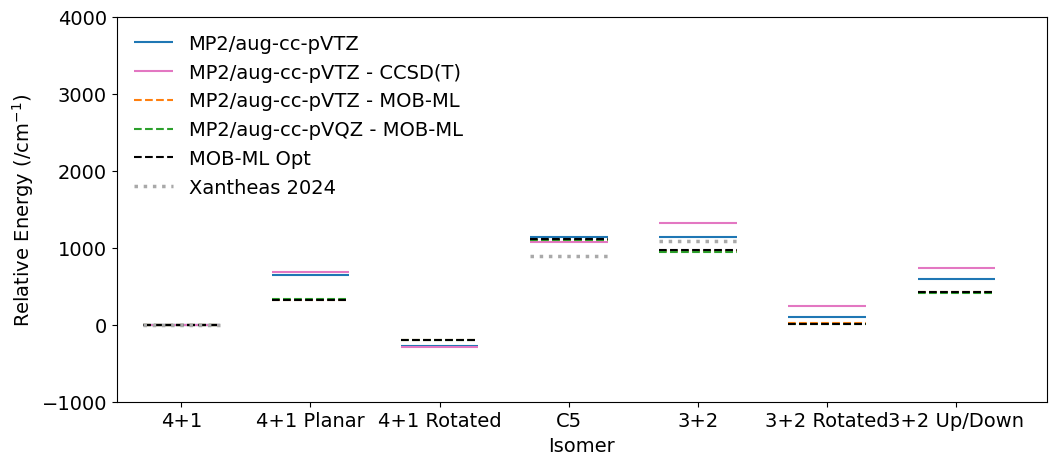

In [344]:
# Plot relative energies of all isomers

plt.rcParams["figure.figsize"] = [12, 5]

for i, energy in enumerate(rel_mp2_tz):
    plt.hlines(energy, 5*(i), 5*(i)+3)
plt.hlines(0, 0, 3, label='MP2/aug-cc-pVTZ')

for i, energy in enumerate(rel_mp2_ccsdt_tz):
    plt.hlines(energy, 5*(i), 5*(i)+3, color = 'tab:pink')
plt.hlines(0, 0, 3, label='MP2/aug-cc-pVTZ - CCSD(T)', color = 'tab:pink')

for i, energy in enumerate(rel_mp2_tz_mobml):
    plt.hlines(energy, 5*(i), 5*(i)+3, color='tab:orange', linestyle='dashed')
plt.hlines(0, 0, 3, label='MP2/aug-cc-pVTZ - MOB-ML', color='tab:orange', linestyle='dashed')

for i, energy in enumerate(rel_mp2_qz_mobml):
    plt.hlines(energy, 5*(i), 5*(i)+3, color='tab:green', linestyle='dashed')
plt.hlines(0, 0, 3, label='MP2/aug-cc-pVQZ - MOB-ML', color='tab:green', linestyle='dashed')

for i, energy in enumerate(rel_mobml_opt):
    plt.hlines(energy, 5*(i), 5*(i)+3, color='black', linestyle='dashed')
plt.hlines(0, 0, 3, label='MOB-ML Opt', color='black', linestyle='dashed')

plt.hlines(2.56*350, 15, 18, label='Xantheas 2024', color='darkgray', linestyle='dotted', linewidth=2.5)
plt.hlines(3.10*350, 20, 23, color='darkgray', linestyle='dotted', linewidth=2.5)
plt.hlines(0, 0, 3, color='darkgray', linestyle='dotted', linewidth=2.5)

plt.legend(fontsize=14, frameon=False, loc='upper left')
plt.xlabel('Isomer')
plt.xlim(-1,35)
plt.xticks(np.arange(1.5,31.5+5, 5), list(df['Isomer']))
plt.ylabel(r'Relative Energy (/cm$^{-1}$)')
plt.ylim(-1000,4000)
plt.show()

### Load in training data generated from MOB-ML DMC simulations

In [240]:
#Dictionaries for the starting timesteps of the various simulation types for each of the starting isomers
#MOB-ML has holes and has to be restarted every time it fails to converge

train_4_1_dict = {'min_starts': [[0], [0, 34]], 'reg_starts': [[0], [0], [0], [0, 528], [0]], 'wide_starts': [[0, 279, 906, 915], [0, 298, 451, 939]], 'test_starts': [[0, 988]]}
train_c5_dict = {'min_starts': [[0, 45, 374, 698, 812], [0, 944]], 'reg_starts': [[0], [0, 128, 411], [0], [0], [0]], 'wide_starts': [[0, 88, 647], [0, 198, 875]], 'test_starts': [[0, 603, 941]]}
train_3_2_dict = {'min_starts': [[0, 82], [0, 68]], 'reg_starts': [[0, 815], [0], [0, 978], [0, 728, 921], [0]], 'wide_starts': [[0, 249, 313, 877], [0, 683]], 'test_starts': [[0, 473]]}
train_3_2_book_dict = {'min_starts': [[0]], 'reg_starts': [[0]], 'wide_starts': [[0]], 'test_starts': [[0]]}
train_3_2_up_down_dict = {'min_starts': [[0]], 'reg_starts': [[0]], 'wide_starts': [[0]], 'test_starts': [[0]]}
train_4_1_planar_dict = {'min_starts': [[0]], 'reg_starts': [[0]], 'wide_starts': [[0]], 'test_starts': [[0]]}
train_4_1_rotated_dict = {'min_starts': [[0, 658, 961]], 'reg_starts': [[0]], 'wide_starts': [[0]], 'test_starts': [[0]]}

In [139]:
file = f'{ml_path}/h11o6/h11o6_0_training_818ts.hdf5'
f = h5py.File(file, "r")
cds = f['coords']
np.save(f'{ml_path}/h11o6/h11o6_3_2_h2o_rot_scaled_818_start.npy', cds)

In [249]:
#energy_shift = -457.8604991*au_to_cm
energy_shift = -457.862801139232*au_to_cm

isomer = '3_2'
sim_type = 'test'
sim_num = 1

if isomer == '3_2':
    train_dict = train_3_2_dict
elif isomer == '4_1':
    train_dict = train_4_1_dict
elif isomer == 'c5':
    train_dict = train_c5_dict
elif isomer == '3_2_book':
    train_dict = train_3_2_book_dict
elif isomer == '3_2_up_down':
    train_dict = train_3_2_up_down_dict
elif isomer == '4_1_planar':
    train_dict = train_4_1_planar_dict
elif isomer == '4_1_rotated':
    train_dict = train_4_1_rotated_dict
else:
    print("Not a valid isomer name")


train_energies_list = []
train_cds_list = []

if sim_type == 'min':
    sim = '500w_1000ts_1dt'
    starts = train_dict['min_starts'][sim_num - 1]
    end = 1000
elif sim_type == 'wide':
    sim = '1000w_1000ts_10dt'
    starts = train_dict['wide_starts'][sim_num - 1]
    end = 1000
elif sim_type == 'reg':
    if isomer in ['4_1', 'c5', '3_2']:
        if sim_num in [1, 2]:
            sim = '200w_5000ts_10dt'
            end = 1000
    else:
        sim = '200w_1000ts_10dt'
        end = 1000


    starts = train_dict['reg_starts'][sim_num - 1]

elif sim_type == 'test':
    sim = '1000w_1000ts_10dt_min'
    starts = train_dict['test_starts'][sim_num - 1]
    end = 1000

else:
    print("Not a valid sim type")

print(f'starting {isomer} {sim_type} sim number {sim_num}')

for j in range(len(starts)):
    print(f'starting at timestep {starts[j]}')

    path = f'{data_path}/mobml_pyscf/{isomer}_min/sim_{sim_num}/{sim}_{starts[j]}_start'

    training_sim = pv.SimInfo(f'{path}/h11o6_0_sim_info.hdf5')
    
    if j+1 < len(starts):
        for b in range(starts[j+1]-starts[j]):
            cds,energies = training_sim.get_training(f'{path}/h11o6_0_training_{b}ts.hdf5',ret_ang=False, ret_cm=True)
            
            train_cds_list.append(cds)
            train_energies_list.append(energies-energy_shift) #record energy relative to 4+1 minimum
            
            #print(f'snapshot {b+starts[j]} done')
    else:
        for b in range(end-starts[j]):
            cds,energies = training_sim.get_training(f'{path}/h11o6_0_training_{b}ts.hdf5',ret_ang=False, ret_cm=True)
            
            train_cds_list.append(cds)
            train_energies_list.append(energies-energy_shift)
            
            #print(f'snapshot {b+starts[j]} done')
     


starting 3_2 test sim number 1
starting at timestep 0
starting at timestep 473


In [192]:
train_4_1_dict = {'min_starts': [[0]], 'wide_starts': [[0]]}
train_4_1_rot_dict = {'min_starts': [[0]], 'wide_starts': [[0,473]]}
train_4_1_planar_dict = {'min_starts': [[0,18,386]], 'wide_starts': [[0]]}
train_c5_dict = {'min_starts': [[0]], 'wide_starts': [[0]]}
train_3_2_dict = {'min_starts': [[0]], 'wide_starts': [[0,218,756]]}
train_3_2_h2o_rot_dict = {'min_starts': [[0, 988]], 'wide_starts': [[0,818]]}
train_3_2_up_down_dict = {'min_starts': [[0]], 'wide_starts': [[0,533]]}

In [193]:
energy_shift = -457.862801139232*au_to_cm

isomer = '4_1_planar'
sim_type = 'wide'
sim_num = 1
if isomer == '3_2':
    train_dict = train_3_2_dict
elif isomer == '4_1':
    train_dict = train_4_1_dict
elif isomer == 'c5':
    train_dict = train_c5_dict
elif isomer == '3_2_h2o_rot':
    train_dict = train_3_2_h2o_rot_dict
elif isomer == '3_2_up_down':
    train_dict = train_3_2_up_down_dict
elif isomer == '4_1_planar':
    train_dict = train_4_1_planar_dict
elif isomer == '4_1_rot':
    train_dict = train_4_1_rot_dict
else:
    print("Not a valid isomer name")


train_energies_list = []
train_cds_list = []

if sim_type == 'min':
    sim = '500w_1000ts_1dt'
    starts = train_dict['min_starts'][sim_num - 1]
    end = 1000
    path_start = f'{data_path}/mobml_pyscf/{isomer}_mobml_opt/sim_{sim_num}'

elif sim_type == 'wide':
    sim = 'scaled_O_x02_1000w_1000ts_10dt'
    starts = train_dict['wide_starts'][sim_num - 1]
    end = 1000
    path_start = f'{data_path}/mobml_pyscf/{isomer}_mp2_qz_min/sim_{sim_num}'
else:
    print("Not a valid sim type")

print(f'starting {isomer} {sim_type} sim number {sim_num}')

for j in range(len(starts)):
    print(f'starting at timestep {starts[j]}')

    path = f'{path_start}/{sim}_{starts[j]}_start'

    training_sim = pv.SimInfo(f'{path}/h11o6_0_sim_info.hdf5')
    
    if j+1 < len(starts):
        for b in range(starts[j+1]-starts[j]):
            cds,energies = training_sim.get_training(f'{path}/h11o6_0_training_{b}ts.hdf5',ret_ang=False, ret_cm=True)
            
            train_cds_list.append(cds)
            train_energies_list.append(energies-energy_shift) #record energy relative to 4+1 minimum
            
            #print(f'snapshot {b+starts[j]} done')
    else:
        for b in range(end-starts[j]):
            cds,energies = training_sim.get_training(f'{path}/h11o6_0_training_{b}ts.hdf5',ret_ang=False, ret_cm=True)
            
            train_cds_list.append(cds)
            train_energies_list.append(energies-energy_shift)
            
            #print(f'snapshot {b+starts[j]} done')

starting 4_1_planar wide sim number 1
starting at timestep 0


In [194]:
min_geom = read_xyz_file(f'{ml_path}/h11o6/geometries/h11o6_{isomer}_mobml_opt_new.xyz')
min_energy = h11o6_mobml_opt_energy_dict[isomer]*au_to_cm - energy_shift

min_energy

522.8313332349062

In [195]:
train_energies_list.append(np.array([min_energy]))
train_cds_list.append(min_geom.reshape(1,17,3))

In [250]:
train_energies = np.concatenate(train_energies_list)
train_cds = np.concatenate(train_cds_list)

In [251]:
#check energy range of simulation
print(np.min(train_energies), np.max(train_energies))

6271.121774151921 127422.09504145384


In [252]:
np.save(f'{ml_path}/h11o6/training_data_old/h11o6_{isomer}_mobml_{sim_type}_sim_{sim_num}_training_cds.npy',train_cds)
np.save(f'{ml_path}/h11o6/training_data_old/h11o6_{isomer}_mobml_{sim_type}_sim_{sim_num}_training_energies_reshifted.npy',train_energies)

### Create full training data sets

In [ ]:
# Load in DMC snapshot data, skipping over timesteps that failed

h11o6_snapshot_cds = np.load(f'{ml_path}/h11o6/training_sets/h11o6_3_2_unguided_100k_75kts_snapshot.npy')
h11o6_dmc_cds = []
h11o6_dmc_energies = []
for i in np.arange(0, len(h11o6_snapshot_cds), 1000):
    try:
        energy = np.load(f'{ml_path}/h11o6/training_sets/h11o6_snapshots/{i}-{i+1000}_3_2_energies.npy')
        h11o6_dmc_energies.append(energy)
        h11o6_dmc_cds.append(h11o6_snapshot_cds[i:i+1000])
    except:
        print(f'Skipping {i}-{i+1000}')
        continue
h11o6_dmc_energies = np.concatenate(h11o6_dmc_energies)*au_to_cm - energy_shift
h11o6_dmc_cds = np.concatenate(h11o6_dmc_cds)

np.save(f'{ml_path}/h11o6/training_data/h11o6_3_2_dmc_energies.npy', h11o6_dmc_energies)
np.save(f'{ml_path}/h11o6/training_data/h11o6_3_2_dmc_cds.npy', h11o6_dmc_cds)

### Compare energy distributions between the different parts of the training data

In [ ]:
def plot_training_data(isomer):

    _, train_min_energies = make_training_set([isomer], ['min'], [[1]])
    _, train_wide_energies = make_training_set([isomer], ['wide'], [[1]])
    _, train_reg_energies = make_training_set([isomer], ['reg'], [[1,2,3,4,5]])
    _, train_test_energies = make_training_set([isomer], ['test'], [[1]])

    dmc_energies = np.load(f'{ml_path}/h11o6/training_data/h11o6_{isomer}_dmc_energies.npy')

    n, bins = np.histogram(train_min_energies, bins=np.arange(0, 100000, 200), density = True)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    plt.plot(bin_centers, n, label = f'{isomer} min')

    n, bins = np.histogram(train_wide_energies, bins=np.arange(0, 100000, 200), density = True)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    plt.plot(bin_centers, n, label = f'{isomer} wide')

    n, bins = np.histogram(train_reg_energies, bins=np.arange(0, 100000, 200), density = True)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    plt.plot(bin_centers, n, label = f'{isomer} reg')

    n, bins = np.histogram(train_test_energies, bins=np.arange(0, 100000, 200), density = True)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    plt.plot(bin_centers, n, label = f'{isomer} test')

    n, bins = np.histogram(dmc_energies, bins=np.arange(0, 100000, 200), density = True)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    plt.plot(bin_centers, n, label = f'{isomer} DMC')

    plt.xlabel(r'MOB-ML Energy (/cm$^{-1}$)')
    plt.ylabel('Density of Points')
    plt.xlim(0, 80000)
    plt.ylim(0, 6e-5)
    plt.legend()
    plt.show()

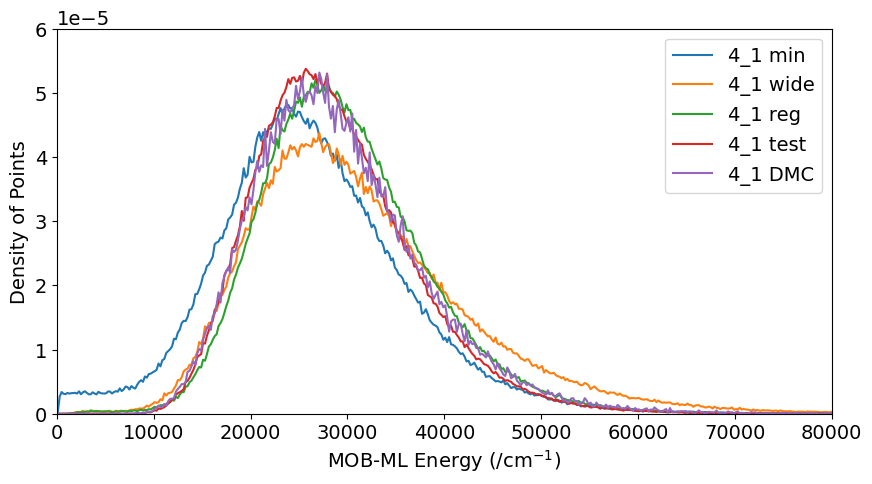

In [219]:
plot_training_data('4_1')

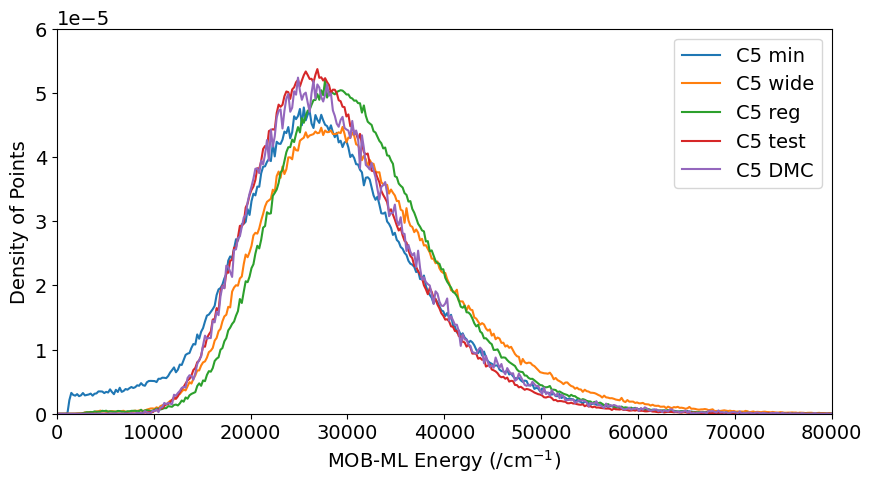

In [220]:
plot_training_data('C5')

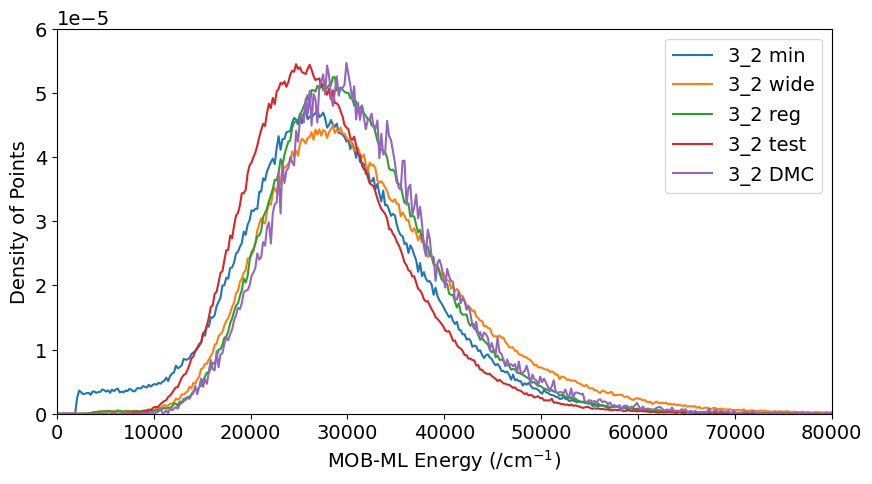

In [221]:
plot_training_data('3_2')

### PCA Analysis of Training Features

In [270]:
# Load in 
sim_type = 'min'
reg_cds, reg_energies = make_training_set(ml_path, 'h11o6', ['4_1','3_2', '3_2_h2o_rot', '3_2_up_down', '4_1_rot', '4_1_planar', 'c5'], [sim_type], [[1]])

In [271]:
import random

# Generate list of indices
indices = list(range(len(reg_cds)))

# Shuffle the indices randomly
random.shuffle(indices)

split_idx = 100000

# Partition the data
test_indices = indices[:split_idx]

test_cds = reg_cds[test_indices]

Reference PCA/KMeans model saved.


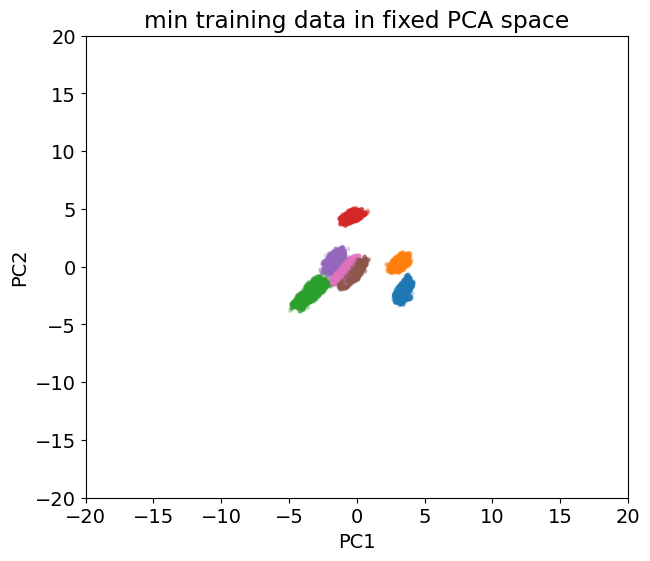

In [272]:
# Load reference structures
# --------------------------------------------------
coords = test_cds      # (N_ref, 17, 3)
oxygen_idx = [0, 3, 6, 9, 12, 15]
oxygen_coords = coords[:, oxygen_idx, :]  # (N_ref, 6, 3)

# --------------------------------------------------
# Build pairwise O–O distance features
# --------------------------------------------------
X = np.array([pdist(oxygen_coords[i]) for i in range(len(coords))])

# --------------------------------------------------
# Fit scaler, PCA, KMeans
# --------------------------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

n_isomers = 7
kmeans = KMeans(n_clusters=n_isomers, n_init=50, random_state=0)
labels = kmeans.fit_predict(X_pca)

# --------------------------------------------------
# Save everything
# --------------------------------------------------
joblib.dump(scaler, f"{ml_path}/h11o6/scaler.joblib")
joblib.dump(pca, f"{ml_path}/h11o6/pca.joblib")
joblib.dump(kmeans, f"{ml_path}/h11o6/kmeans.joblib")

np.save(f"{ml_path}/h11o6/X_pca_ref.npy", X_pca)
np.save(f"{ml_path}/h11o6/labels_ref.npy", labels)

print("Reference PCA/KMeans model saved.")

# --------------------------------------------------------
# 5. Plot PC1 vs PC2
# --------------------------------------------------------
plt.figure(figsize=(7,6))
#plt.xlim(-6, 6)
#plt.ylim(-6, 6)

# Define the colors you want for each cluster
cluster_colors = {
    0: "tab:blue",
    1: "tab:purple",
    2: "tab:pink",
    3: "tab:red",
    4: "tab:orange",
    5: "tab:green",
    6: "tab:brown"
}

# Map labels to colors
colors = [cluster_colors[lbl] if lbl in cluster_colors else "gray" for lbl in labels]

plt.scatter(X_pca[:,0], X_pca[:,1], c=colors, s=6, alpha=0.2)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.xlim(-20,20)
plt.ylim(-20,20)
plt.title(f"{sim_type} training data in fixed PCA space")
plt.show()

# --------------------------------------------------------
# 6. Identify representative / centroid geometries per cluster
# --------------------------------------------------------
# coords: full 17-atom geometries
# labels: cluster assignments from KMeans
n_clusters = len(np.unique(labels))
centroid_geometries_full = []

for lbl in range(n_clusters):
    cluster_idx = np.where(labels == lbl)[0]  # indices of structures in this cluster
    cluster_coords = coords[cluster_idx]      # shape: (n_cluster, 17, 3)
    centroid = cluster_coords.mean(axis=0)    # shape: (17, 3)
    centroid_geometries_full.append(centroid)

# Convert to array
centroid_geometries_full = np.array(centroid_geometries_full)  # shape: (n_clusters, 17, 3)

In [150]:
for i, geom in enumerate(centroid_geometries_full):
    save_xyz_file(f'{ml_path}/h11o6/geometries/h11o6_{sim_type}_pca_{n_isomers}_isomer_{i+1}.xyz', h11o6_atom_names, centroid_geometries_full[i]*au_to_ang)

### Project new set of training data onto saved PCA model from above

In [203]:
# Load in 
sim_type = 'wide'
cds, energies = make_training_set(ml_path,'h11o6',['c5','4_1','3_2_up_down','4_1_rot','3_2','3_2_h2o_rot','4_1_planar'], [sim_type], [[1]])

In [204]:
import random

# Generate list of indices
indices = list(range(len(cds)))

# Shuffle the indices randomly
random.shuffle(indices)

split_idx = 1000000

# Partition the data
test_indices = indices[:split_idx]

test_cds = cds[test_indices]

In [283]:
old_wide_data = np.load(f'{ml_path}/h11o6/training_data_old/h11o6_3_2_mobml_wide_sim_1_training_cds.npy')

In [284]:
new_wide_data = np.load(f'{ml_path}/h11o6/training_data/h11o6_3_2_mobml_wide_sim_1_training_cds.npy')

New data projected into reference PCA/KMeans space.


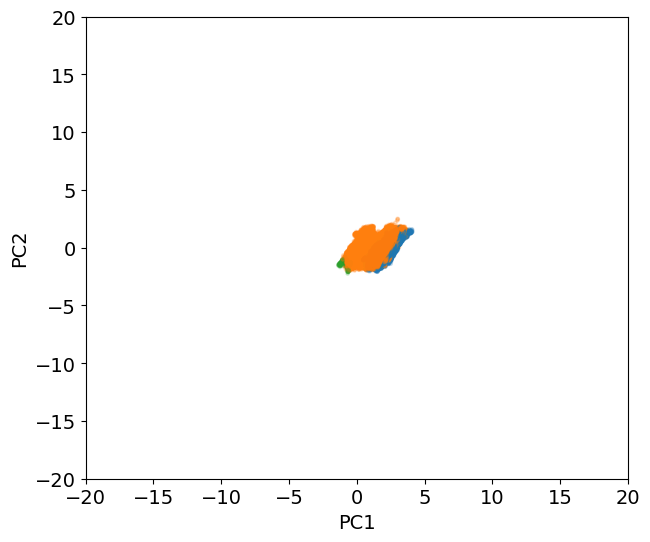

In [286]:
# --------------------------------------------------
# Load trained models
# --------------------------------------------------
scaler = joblib.load(f"{ml_path}/h11o6/scaler.joblib")
pca = joblib.load(f"{ml_path}/h11o6/pca.joblib")
kmeans = joblib.load(f"{ml_path}/h11o6/kmeans.joblib")

# --------------------------------------------------
# Load new structures
# --------------------------------------------------
coords_new = old_wide_data # (N_new, 17, 3)
oxygen_idx = [0, 3, 6, 9, 12, 15]
oxygen_coords_new = coords_new[:, oxygen_idx, :]

# --------------------------------------------------
# Build features
# --------------------------------------------------
X_new = np.array([pdist(oxygen_coords_new[i]) for i in range(len(coords_new))])

# --------------------------------------------------
# Apply scaler → PCA → KMeans
# --------------------------------------------------
X_new_scaled = scaler.transform(X_new)
X_new_pca = pca.transform(X_new_scaled)
labels_new = kmeans.predict(X_new_pca)

np.save(f"{ml_path}/h11o6/X_pca_new.npy", X_new_pca)
np.save(f"{ml_path}/h11o6/labels_new.npy", labels_new)

print("New data projected into reference PCA/KMeans space.")

# Map labels to colors
colors = [cluster_colors[lbl] if lbl in cluster_colors else "gray" for lbl in labels_new]

plt.figure(figsize=(7,6))
plt.scatter(X_new_pca[:,0], X_new_pca[:,1], c=colors, s=6, alpha=0.2)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.xlim(-20, 20)
plt.ylim(-20, 20)
#plt.title(f"{sim_type} data in fixed PCA space")
plt.show()

### Save structures with min and max PC1 and PC2 elements

In [111]:
# Project reference structures into PCA space
X_pca = pca.transform(scaler.transform(X))

# Choose extreme structures along PC2
idx_min = np.argmin(X_pca[:, 1])
idx_max = np.argmax(X_pca[:, 1])

geom_min = coords[idx_min]  # full geometry
geom_max = coords[idx_max]

save_xyz_file(f"{ml_path}/h11o6/geometries/pc2_min_geom.xyz", h11o6_atom_names, geom_min*au_to_ang)
save_xyz_file(f"{ml_path}/h11o6/geometries/pc2_max_geom.xyz", h11o6_atom_names, geom_max*au_to_ang)


### Generate NN Model Training Set

In [207]:
# Load in 
sim_type = 'min'
min_cds, min_energies = make_training_set(ml_path,'h11o6',['c5','4_1','3_2_up_down','4_1_rot','3_2','3_2_h2o_rot','4_1_planar'], [sim_type], [[1]])

In [210]:
import random

# Generate list of indices
indices = list(range(len(min_cds)))

# Shuffle the indices randomly
random.shuffle(indices)

split_idx = 500000

# Partition the data
sample_indices = indices[:split_idx]

min_cds_sample = min_cds[sample_indices]
min_energies_sample = min_energies[sample_indices]

In [212]:
# Load in 
sim_type = 'wide'
wide_cds, wide_energies = make_training_set(ml_path,'h11o6',['c5','4_1','3_2_up_down','4_1_rot','3_2','3_2_h2o_rot','4_1_planar'], [sim_type], [[1]])

In [213]:
import random

# Generate list of indices
indices = list(range(len(wide_cds)))

# Shuffle the indices randomly
random.shuffle(indices)

split_idx = 1500000

# Partition the data
sample_indices = indices[:split_idx]

wide_cds_sample = wide_cds[sample_indices]
wide_energies_sample = wide_energies[sample_indices]

In [214]:
isomers = ['c5','4_1','3_2_up_down','4_1_rot','3_2','3_2_h2o_rot','4_1_planar']
min_geoms = []
min_energies = []
for isom in isomers:
    min_geom = read_xyz_file(f'{ml_path}/h11o6/geometries/h11o6_{isom}_mobml_opt_new.xyz')
    min_energy = h11o6_mobml_opt_energy_dict[isom]*au_to_cm - energy_shift
    min_geoms.append(min_geom)
    min_energies.append(min_energy)
min_geoms = np.array(min_geoms)
min_energies = np.array(min_energies)


In [216]:
training_cds = np.concatenate([min_cds_sample, wide_cds_sample, min_geoms])
training_energies = np.concatenate([min_energies_sample, wide_energies_sample, min_energies])

In [220]:
np.save(f'{ml_path}/h11o6/training_data/h11o6_all_isoms_500k_min_1500k_wide_cds.npy',training_cds)
np.save(f'{ml_path}/h11o6/training_data/h11o6_all_isoms_500k_min_1500k_wide_energies.npy',training_energies)

In [297]:
old_energies = np.load(f"{ml_path}/h11o6/training_data_old/h11o6_3_2_dmc_energies.npy")

In [298]:
new_energies = old_energies + 505.2392118126154

In [299]:
np.save(f"{ml_path}/h11o6/training_data_old/h11o6_3_2_dmc_energies_reshifted.npy", new_energies)

In [ ]:
mobml_cds = np.load(f"{ml_path}/h11o6/training_data/h11o6_3_2_up_down_egnn_all_isomers_unguided_495500ts_cds.npy")
cds_sliced = np.concatenate([mobml_cds[:14000],mobml_cds[15000:]])
np.save(f"{ml_path}/h11o6/training_data/h11o6_3_2_up_down_egnn_all_isomers_unguided_49500ts_cds.npy",cds_sliced)

In [21]:
cds_sliced.shape

(98759, 17, 3)

In [22]:
mobml_energies = np.load(f"{ml_path}/h11o6/training_data/h11o6_3_2_up_down_egnn_all_isomers_unguided_49500ts_mobml_energies/final_energies.npy")
energies_shifted = (mobml_energies - -457.862801139232)*au_to_cm
np.save(f"{ml_path}/h11o6/training_data/h11o6_3_2_up_down_egnn_all_isomers_unguided_49500ts_mobml_energies/final_energies_shifted.npy",energies_shifted)

### NN Model Error Analysis

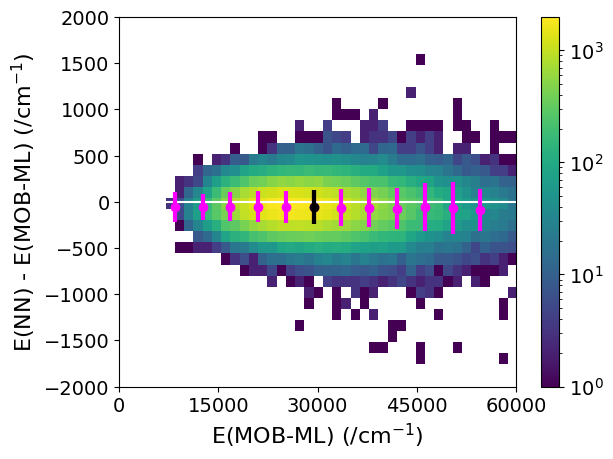

MAE: 153.86, average error: -58.00


In [23]:
plot_egnn_2d_pred_errors(f"{ml_path}/h11o6/models/egnn/h11o6_egnn_all_64_3_3_ln_best.pth",
                    f"{ml_path}/h11o6/training_data/h11o6_3_2_up_down_egnn_all_isomers_unguided_49500ts_cds.npy",
                    f"{ml_path}/h11o6/training_data/h11o6_3_2_up_down_egnn_all_isomers_unguided_49500ts_mobml_energies/final_energies_shifted.npy")

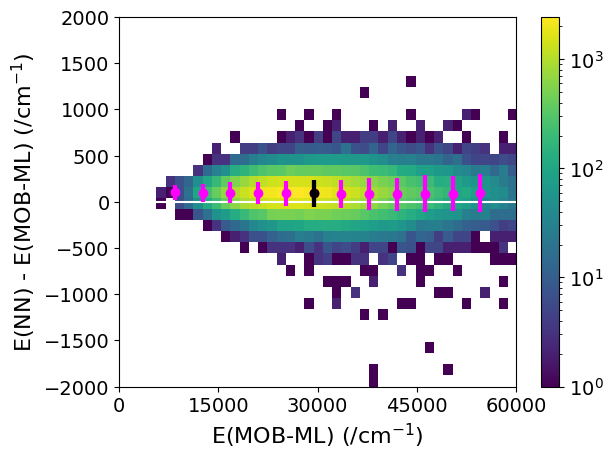

MAE: 135.34, average error: 89.74


In [301]:
plot_egnn_2d_pred_errors(f"{ml_path}/h11o6/models/egnn/h11o6_egnn_all_64_3_3_ln_best.pth",
                    f"{ml_path}/h11o6/training_data_old/h11o6_c5_dmc_cds.npy",
                    f"{ml_path}/h11o6/training_data_old/h11o6_c5_dmc_energies_reshifted.npy")

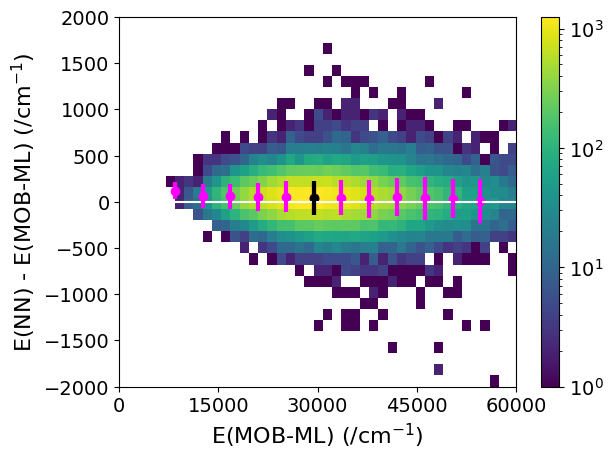

MAE: 142.41, average error: 45.43


In [302]:
plot_egnn_2d_pred_errors(f"{ml_path}/h11o6/models/egnn/h11o6_egnn_all_64_3_3_ln_best.pth",
                    f"{ml_path}/h11o6/training_data_old/h11o6_3_2_dmc_cds.npy",
                    f"{ml_path}/h11o6/training_data_old/h11o6_3_2_dmc_energies_reshifted.npy")

## DMC Simulation Analysis

### Energy Analysis

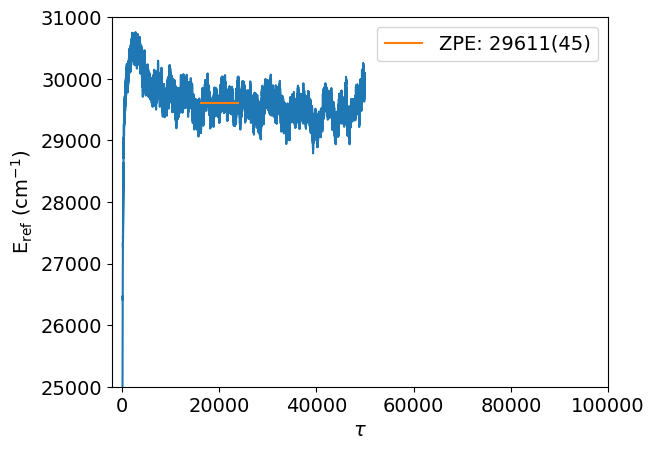

29611 0


In [16]:
ZPEs = []

isomer = "3_2"
model_type = "EGNN"
all_isoms = True
guided = False

if model_type == "EGNN":
    if all_isoms:
        if guided:
            model = "all_isomers/64_3layers_3freqs_6decay_1gradclip_2mill_std_energies/h2o_guided"
        else:
            model = "all_isomers/64_3layers_3freqs_6decay_1gradclip_2mill_std_energies/unguided"
    else:
        if guided:
            model = "64_3layers_3freqs_6decay_1gradclip_2mill_std_energies/gpu/h2o_guided"
        else:
            model = "64_3layers_3freqs_6decay_1gradclip_2mill_std_energies/gpu/unguided"
elif model_type == "NN":
    if isomer in ["3_2_up_down", "3_2_book", "3_2"]:
        model = "450_3hidden_6_decay_molec_atom_sort_standardized/model_5_reg_no_B/dist_65_energy_1"
    else:
        model = "450_3hidden_6_decay_molec_atom_sort_standardized/model_5_reg/dist_65_energy_1"

walkers = 100000
timesteps = 50000

start_time = 16000
end_time = 24000
step = (end_time - start_time) // 5

tau = np.linspace(0,timesteps,timesteps)
for i in range(1):
    #tutorial_sim = pv.SimInfo('C:/Users/gjaco/OneDrive/Documents/UW/McCoy Group/H11O6-/Data/NN_Data/3_2_start/450_3hidden_6_decay_0_dropout_2mill_revised_molec_atom_sort_standardized/model_5_reg/dist_65_energy_1/h2o_guided/1.0w_100000_walkers_50000t_1dt/H11O6_{2}_sim_info.hdf5'.format(walkers,timesteps,i))
    tutorial_sim = pv.SimInfo(f'{data_path}/{model_type}_Data/{isomer}_start/{model}/1.0w_{walkers}_walkers_{timesteps}t_1dt/H11O6_{i}_sim_info.hdf5')

    vref = tutorial_sim.get_vref(ret_cm=True)

    means = []
    for j in range(start_time,end_time,step):
        mean = np.mean(vref[j:j+step,1])
        means.append(mean)

    std = np.std(means)
    
    plt.plot(tau,vref[:,1],
             #label=f'ZPE: {ZPE:.0f}({std:.0f})'
             )
    

    ZPE = np.mean(vref[start_time:end_time,1])
    ZPEs.append(ZPE)

    plt.hlines(ZPE,start_time,end_time,color='tab:orange',label=f'ZPE: {ZPE:.0f}({std:.0f})')
    #plt.hlines(29123, 0,100000,color='black',linestyle='dashed',label='4+1 ZPE: 29 123')

    plt.ylabel(r'E$_\mathrm{ref}$ (cm$^{-1}$)')
    plt.xlabel(r'$\tau$')
    plt.xlim(-2000,100000)
    plt.ylim(25000,31000)
    plt.legend()
    plt.show()

print(round(np.mean(ZPEs)), round(np.std(ZPEs)))


In [326]:
manual_ZPEs = [29154, 29134, 29161]
print(round(np.mean(manual_ZPEs)), round(np.std(manual_ZPEs)))

29150 11


### Save representative geometry from a given simulation timestep

In [17]:
sim_num = 0
snapshot = 2500
max_cds = get_max_wt_wfn(f'{data_path}/{model_type}_Data/{isomer}_start/{model}/1.0w_{walkers}_walkers_{timesteps}t_1dt/wfns/H11O6_{sim_num}_wfn_{snapshot}ts.hdf5')
save_xyz_file(f'{ml_path}/h11o6/geometries/h11o6_{isomer}_unguided_{sim_num}_max_{snapshot}ts.xyz',h11o6_atom_names,max_cds*au_to_ang)

In [18]:
filename = f'{data_path}/{model_type}_Data/{isomer}_start/{model}/1.0w_{walkers}_walkers_{timesteps}t_1dt/wfns/H11O6_{sim_num}_wfn_{snapshot}ts.hdf5'
f = h5py.File(filename, "r")
cds = f['coords']
weights = f['desc_wts']

In [19]:
np.save(f'{ml_path}/h11o6/training_data/h11o6_{isomer}_egnn_all_isomers_unguided_{snapshot}ts_cds.npy',cds)

In [334]:

energy_list = []
for start in range(0, 9952, 1000):
    end = min(start+1000, 9952)
    print(start, end)


0 1000
1000 2000
2000 3000
3000 4000
4000 5000
5000 6000
6000 7000
7000 8000
8000 9000
9000 9952


### Wavefunction analysis

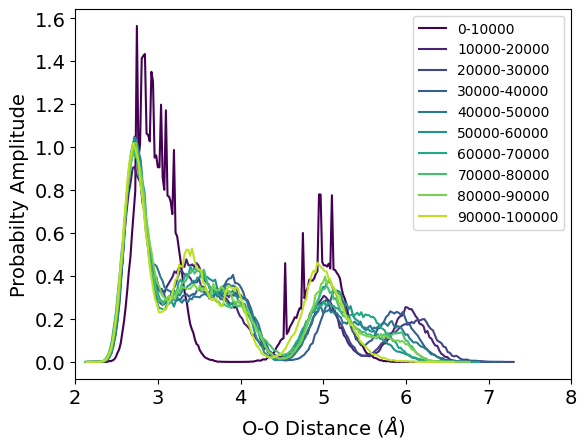

In [13]:
from itertools import combinations

isomer = "c5"
model_type = "NN"

if model_type == "EGNN":
    model = "64_3layers_3freqs_6decay_1gradclip_2mill_std_energies/gpu"
elif model_type == "NN":
    model = "450_3hidden_6_decay_0_dropout_2mill_revised_molec_atom_sort_standardized/model_5_reg/dist_65_energy_1"

sim_num = 0
walkers = 100000
timesteps = 100000

starts = np.arange(0,100000,10000)

cmap = plt.cm.viridis

# Generate a list of colors from the colormap
colors = [cmap(i / len(starts)) for i in range(len(starts))]

for i in range(len(starts)):

    snapshots = np.arange(starts[i],starts[i]+5000,500)

    tutorial_sim = pv.SimInfo(f'{data_path}/{model_type}_Data/{isomer}_start/{model}/h2o_guided/1.0w_{walkers}_walkers_{timesteps}t_1dt/H11O6_{sim_num}_sim_info.hdf5')
    coords, weights = tutorial_sim.get_wfns(snapshots)
    coords = pv.Constants.convert(coords,'angstroms',to_AU=False) # Conversion of cds to angstroms

    analyzer = pv.AnalyzeWfn(coords)

    oxygens = [0, 3, 6, 9, 12, 15]
    OOs = list(combinations(oxygens, 2))

    oo_cumulative = []
    total_dws = []
    for pair in OOs:
        bond_length = analyzer.bond_length(pair[0],pair[1])
        oo_cumulative.append(bond_length)
        total_dws.append(weights)

    oo_total = np.concatenate(oo_cumulative)
    total_dws = np.concatenate(total_dws)

    n, bins = np.histogram(oo_total,weights=total_dws,bins=200,density=True)
    bin_centers = (bins[:-1] + bins[1:]) / 2

    plt.plot(bin_centers,n,color=colors[i],label=f'{starts[i]}-{starts[i]+10000}')

plt.legend(fontsize=10)
plt.xlim(2,8)
plt.xlabel(r'O-O Distance ($\AA$)')
#plt.ylim(0,1)
plt.ylabel('Probabilty Amplitude')
plt.show()